[![Salt Identification](https://pbs.twimg.com/media/DilKBjUVsAA74j1.jpg)](wwww.kaggle.com/)


In [ ]:
# Import libraries

# OS
import sys
import random
import warnings
import os
import time

# Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from tqdm.notebook import trange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# Deep Learning
import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, RepeatVector, Reshape, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [ ]:
# Load Data using Kaggle API
# First we must go to Kaggle and generate a new API Token
# Then, upload that token manually to google colab

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eloukas","key":"71b484ded34690cb3613ac4f7da682c5"}'}

In [ ]:
# Store it in a specific (hidden) folder with the correct permissions; otherwise we get error
!mkdir -p ~/.kaggle  # Create a hidden folder 
!cp kaggle.json ~/.kaggle/  # Copy the .json  there
!chmod 600 ~/.kaggle/kaggle.json  # RW permissions for owner, aka me

In [ ]:
# Then, we can download our dataset directly from kaggle using its API 
!kaggle competitions download -c tgs-salt-identification-challenge

 87% 33.0M/37.9M [00:00<00:00, 34.4MB/s]
100% 37.9M/37.9M [00:00<00:00, 48.6MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 82.2MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 131MB/s]
  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 106MB/s]
 90% 194M/217M [00:03<00:00, 44.1MB/s]
100% 217M/217M [00:03<00:00, 68.4MB/s]
 80% 33.0M/41.4M [00:00<00:00, 28.5MB/s]
100% 41.4M/41.4M [00:00<00:00, 60.7MB/s]
 93% 152M/163M [00:01<00:00, 68.5MB/s]
100% 163M/163M [00:02<00:00, 84.8MB/s]


In [ ]:
# Explore folder
!ls

competition_data.zip  flamingo.zip  sample_data		   test.zip   train.zip
depths.csv	      kaggle.json   sample_submission.csv  train.csv


In [ ]:
# Let's uzip the training files 
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/d80ead8703.png   
  inflating: images/b012e9ebb0.png   
  inflating: images/d3034e7a60.png   
  inflating: images/ae2ef70d51.png   
  inflating: images/1af44a9db0.png   
  inflating: images/41cfd4b320.png   
  inflating: images/853e89d0d3.png   
  inflating: images/2a484baa26.png   
  inflating: images/92e617896e.png   
  inflating: images/b70f0ab0c2.png   
  inflating: images/e8757626a1.png   
  inflating: images/6a3d92ce59.png   
  inflating: images/127ef4105f.png   
  inflating: images/d21012f5c1.png   
  inflating: images/1cb9549d2c.png   
  inflating: images/e030bdae65.png   
  inflating: images/0cf7155eb6.png   
  inflating: images/badb3ea766.png   
  inflating: images/9bd58061d6.png   
  inflating: images/2b1e71c2a3.png   
  inflating: images/28d42de29f.png   
  inflating: images/10833853b3.png   
  inflating: images/ef13247eed.png   
  inflating: images/bce104494c.png   
  inflating: images/c8ce151a18.png   

In [ ]:
!ls
# We now have an images and masks folder

competition_data.zip  images	   sample_data		  train.csv
depths.csv	      kaggle.json  sample_submission.csv  train.zip
flamingo.zip	      masks	   test.zip


In [ ]:
# Let's get some descriptive statistics abour our train and masks.
# These CSV files are comma-separated.
train_df = pd.read_csv('train.csv', index_col='id')
depths_df = pd.read_csv('depths.csv', index_col='id')

print(train_df.describe())
print(depths_df.describe())

         rle_mask
count        2438
unique       2401
top     1617 8585
freq            4
                  z
count  22000.000000
mean     506.453318
std      208.605991
min       50.000000
25%      352.000000
50%      513.000000
75%      671.000000
max      959.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Depth distribution')

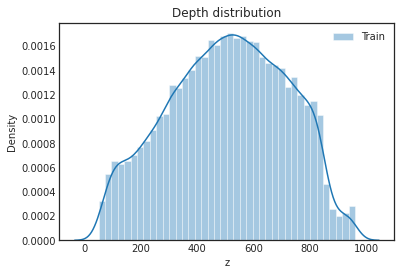

In [ ]:
sns.distplot(depths_df.z, label="Train")
#sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [ ]:
# Let's dig into the format of the pandas dataframes
# Rename 'z' dimension to depth to be interpreted more easily
depths_df.rename(columns={'z': 'depth'}, inplace=True)
depths_df.head()


,depth
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783


In [ ]:
train_df.head()

,rle_mask
id,
575d24d81d,NaN
a266a2a9df,5051 5151
75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


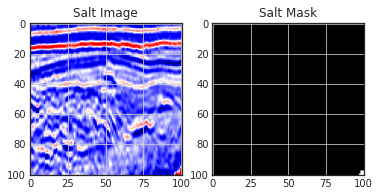

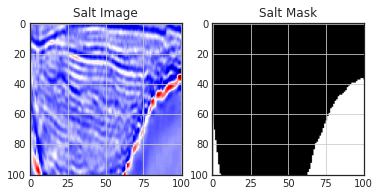

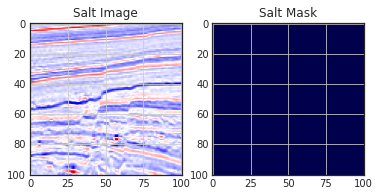

In [ ]:
# Let's see some of the images
def plot_image_mask(image, mask):

    f, axarr = plt.subplots(1,2)  # create two subplots

    for i in range(2):
        obj_to_print = image if i == 0 else mask
        title = 'Salt Image' if i == 0 else 'Salt Mask'
        axarr[i].imshow(obj_to_print, cmap='seismic')
        axarr[i].grid()
        axarr[i].set_title(title)
    

for id in ['6c40978ddf','5b7c160d0d', '7e5a6e5013']:  # Print some random images along with their masks
        image = load_img('images/' + id +'.png', color_mode='grayscale')
        mask = load_img('masks/' + id +'.png', color_mode='grayscale')
        plot_image_mask(image, mask)
    

255
255


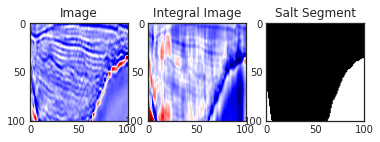

In [ ]:
# I see that they use the cumulative sum of the pixels in the contest. 
# From a quick search, there are some alternate wordings for it, like 'integral image' or the summed-area table.
# They are used in computer vision/graphics applications and they express the sum of values in a rectangular subset

# References:
# https://www.seas.upenn.edu/~cis565/Lectures2011/Lecture15_SAT.pdf
# https://en.wikipedia.org/wiki/Summed-area_table

# Let's visualize one cumulative sum (2nd figure)
image = load_img('images/' + '5b7c160d0d' + '.png', color_mode='grayscale')
image = np.array(image)  
image_cumsum = (np.float32(image)-image.mean()).cumsum(axis=0)
f, axarr = plt.subplots(1,3)  # create two subplots

axarr[0].imshow(image, cmap='seismic')
axarr[0].set_title('Image')
axarr[1].imshow(image_cumsum, cmap='seismic')
axarr[1].set_title('Integral Image')
mask = load_img('masks/' + '5b7c160d0d' +'.png')
axarr[2].imshow(mask, cmap='seismic')
axarr[2].set_title('Salt Segment')

print(image.max())

print(np.array(mask).max())

In [ ]:
# We could also think the cumulative sum as a way of augmentation step since it expresses the same image but in a different way.
# For example, we could store it as a different training example, but since the original image and the integral image are not from the same origin,
# we will append the cumsum image as the 2nd channel of input in our CNN.

In [ ]:
# Get train images
train_ids = train_df.index.tolist()
new_train_ids = [] 

for elem in train_ids:
    elem += '.png'
    new_train_ids.append(elem)

train_ids = new_train_ids
del new_train_ids
train_ids[:5]

['575d24d81d.png',
 'a266a2a9df.png',
 '75efad62c1.png',
 '34e51dba6a.png',
 '4875705fb0.png']

In [ ]:
# Set some parameters
im_width = 128  # Width
im_height = 128  # Height
border = 5  # Border used in the integral image
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth

In [ ]:
# In order to get our data ready, we need to reshape them to the appropriate shapes

# Our images (Xs) will be of 3D shape. Each training sample/instance will have a [height] x [width] x [#channels] shape
# While our masks (Ys) will be of 2D shape. Each label will have a [height] x [width] shape

# Reference notebooks:
# https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics#Data-Exploration
# https://www.kaggle.com/bguberfain/unet-with-depth/notebook

# We will initialize a NumPy array as bove
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)

# In case you want to use the depth as an extra feature:
# Depth is a scalar, so it is 1D
X_depth = np.zeros((len(train_ids), n_features), dtype=np.float32)

# For each training instance, we will populate it accordingly.
for index, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    '''
        index -- the counting index starting from 0
        id -- 'XXXXXXXX.png'
    '''
    
    # Get depth
    # Attach it to the [#train_ids] x [1] array
    # Be sure to ignore the file extension (.png) for the depths.csv file
    X_depth[index] = depths_df.loc[id_[:-4], 'depth']  

    # Get Xs (channel #1)
    # Reference:
    # https://www.tensorflow.org/tutorials/images/classification
    x_image = img_to_array(load_img('images/' + id_, color_mode="grayscale"))

    # Using skimage, we resize it to be ready for the U-Net that we will later develop.
    # U-Nets use power of 2s, so we rescale the image to 128 x 128 in 1 channel.
    # Originally, images are 101 x 101. This can be seen just by right clicking any file in the explorer.
    # The extra 27 pixels will be padded with a constant so we have no zeros when convoluting.
    x_image = resize(x_image, (128, 128, 1), mode='constant', preserve_range=True)

    # Get Integral Image (channel #2) as shown in many kaggle notebooks
    # Imitates a seismic inversion
    x_center_mean = x_image[border:-border, border:-border].mean()
    x_csum = (np.float32(x_image)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Get Ys
    # Same as before, each image/mask is an 128 x 128 image.
    # Already grayscaled
    mask = img_to_array(load_img('masks/' + id_)) 
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Values for each pixel, for each image/mask/ are between 0 and 255,
    # so we will normalize them to get a smoother loss landscape for our neural network

    # We use squeeze to omit the extra single - dimension
    # Reference:
    # https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html
    X[index, ..., 0] = x_image.squeeze() / 255
    X[index, ..., 1] = x_csum.squeeze()  # Already normalized above
    y[index] = mask / 255

    

In [ ]:
# Since test values are hidden inside Kaggle for the competition, we will select a subset for our training data and a subset for our dev dataset, on which we will evalute.
X_train, X_dev, X_depth_train, X_depth_dev, y_train, y_dev = train_test_split(X, X_depth, y, test_size=0.2, random_state=42)
# 0.2 was randomly chosen

In [ ]:
X_depth_train

array([[648.],
       [616.],
       [447.],
       ...,
       [581.],
       [844.],
       [382.]], dtype=float32)

In [ ]:
# Our images are 128 x 128 NumPy arrays that contain normalized float numbers from 0 to 1
# Depth is a scalar with a minimum of 50 and a maximum of 959.
# If we keep the depth values like this, we will have higher chances of our NN getting stuck in a local optima.
# To avoid that, we normalize our values.

# References:
# https://ieeexplore.ieee.org/document/589532
# https://karpathy.github.io/2019/04/25/recipe/
# https://stats.stackexchange.com/questions/41704/how-and-why-do-normalization-and-feature-scaling-work
# https://www.jeremyjordan.me/batch-normalization/

# We use sklearn's Standard scaler which removes the mean and scales to the unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_depth_train)

X_depth_train = scaler.transform(X_depth_train)
X_depth_dev = scaler.transform(X_depth_dev)  # Also apply this to the development dataset

In [ ]:
X_depth_train
# We now see that our data values came in a more smoother range 

array([[ 0.69102925],
       [ 0.53768414],
       [-0.27216956],
       ...,
       [ 0.369963  ],
       [ 1.6302679 ],
       [-0.5836517 ]], dtype=float32)

In [ ]:
# Check if training data looks all right

def plot_images(X, y, preds=None, ix=None):
    
    if not ix:
        ix = random.randint(0, len(X))
    print(f'Image with index {ix}')
    has_mask = y[ix].max() > 0  

    number_of_subplots = 3
    try:
        if preds.any():
            number_of_subplots = 4
    except AttributeError:
        number_of_subplots = 3

    fig, ax = plt.subplots(1, number_of_subplots, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic', interpolation='bilinear')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic Image')

    ax[1].imshow(X[ix, ..., 1], cmap='seismic', interpolation='bilinear')
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Seismic Integral Image')


    ax[2].imshow(y[ix].squeeze(), interpolation='bilinear', cmap='gray')
    ax[2].set_title('Salt Segment')

    if number_of_subplots == 4:
        ax[3].imshow(preds[ix].squeeze(), interpolation='bilinear', cmap='gray')  
        if has_mask:
            ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
        ax[3].set_title('Salt Pred');
    


Image with index 880


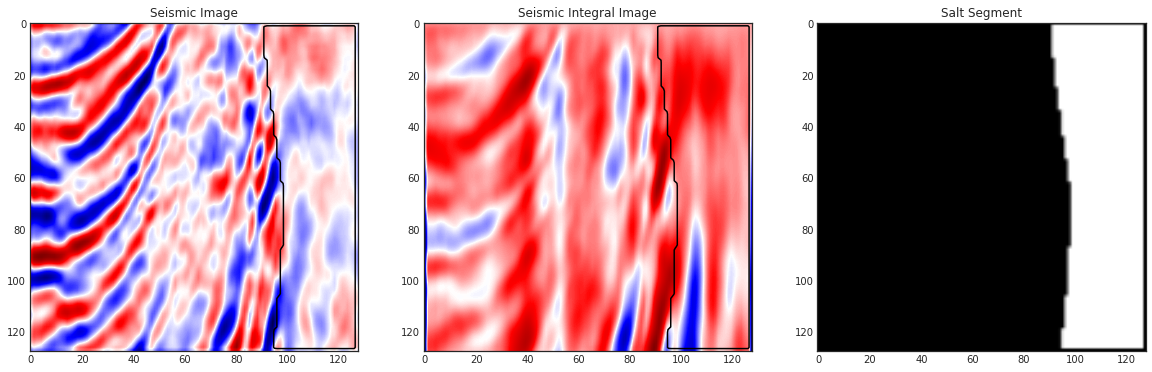

In [ ]:
# Let's visualize a random example
plot_images(X_train, y_train, ix=880)

In [ ]:
# After splitting our data, we might want to perform data augmentation in our training set.
# Care, we need to also take care of the integral image channel, as well as the depth feature for each sample. Otherwise, we will have NaN features.

# We will flip an image froflm left to right 
# Reference:
# https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right

augmented_X_train =  tf.image.flip_left_right(X_train).numpy()  # Flip Xs
augmented_y_train = tf.image.flip_left_right(y_train).numpy()  # Flip Ys accordingly
X_depth_train_for_aug = X_depth_train  # Depth does not change


First picture: Original example
Image with index 880
Second picture: Augmented Example
Image with index 880


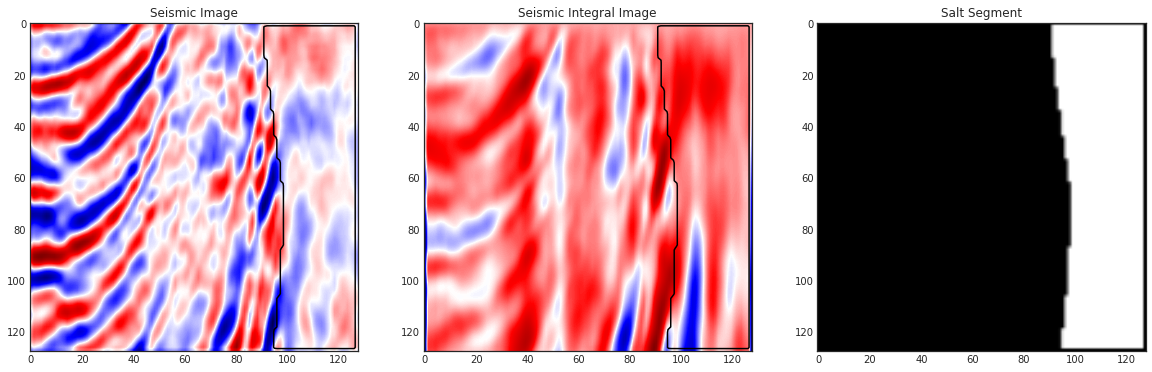

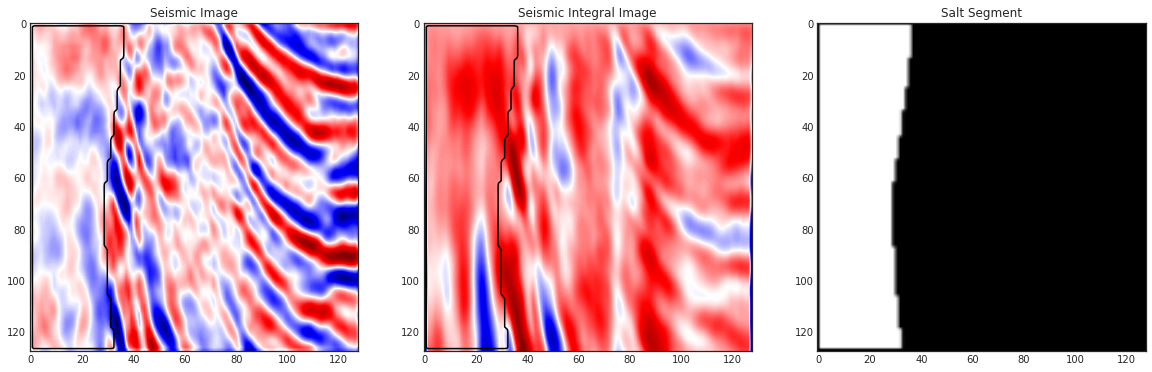

In [ ]:
# Let's also visualize the augmentation that we've done
ix = 880

print('First picture: Original example')
plot_images(X=X_train, y=y_train, ix=ix)

print('Second picture: Augmented Example')
plot_images(X=augmented_X_train, y=augmented_y_train, ix=ix)



In [ ]:
# Now, it is time to append the augmented data to the *training* set.
print(f'Before augmentation:  {X_train.shape, X_depth_train.shape, y_train.shape}')

assert X_train.shape == augmented_X_train.shape 
assert X_depth_train.shape == X_depth_train_for_aug.shape
assert y_train.shape == augmented_y_train.shape
X_train = np.append(X_train, augmented_X_train, axis=0)
y_train = np.append(y_train, augmented_y_train, axis=0)
X_depth_train = np.append(X_depth_train, X_depth_train_for_aug, axis=0)  # Augmented depths are equal to the original depths in any case.

print(f'After augmentation:  {X_train.shape, X_depth_train.shape, y_train.shape}')

Before augmentation:  ((3200, 128, 128, 2), (3200, 1), (3200, 128, 128, 1))
After augmentation:  ((6400, 128, 128, 2), (6400, 1), (6400, 128, 128, 1))


# Neural Network Architecture
U-Nets are famous in the TGS Salt identification challenge (https://www.kaggle.com/c/tgs-salt-identification-challenge/notebooks).

References: 
* https://arxiv.org/abs/1505.04597
* https://paperswithcode.com/method/u-net

U-Net's architecture is designed as an autoencoder consisting of an encoder that contracts and a decoder that expands the information.

U-Net predicts segments for each pixel of the image. So that's why this architecture is useful in our model, as we want to predict salty pixels.

Example image of the network:
[![U-NET](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

U-Net works by encoding the information with convolutional blocks and maxpooling. This downsamples the information as you can see in the bottom of the above image. Then, the decoder upsamples this information and uses concatenations (like ResNets) and convolutions to have a decompressed high-dimensional representation again, just like in the start.

Last but not least, the horizontal connections in the figure represent some skip-connections. So, while the data is propagating and being compressed/decompressed, the neural network also feeds the data to the last layers, which results in a much smoother loss landscape when optimizing, yielding better results.

The name U-Net is taken from the shape of the net :)

In [ ]:
def conv_block(filters_count, kernel_size_tuple, input, dropout):
    """
        Creates a convolutional block with same padding and ReLU activation.

        The block consists of a spatial convolution with the input and the image itself
        along with a 2x2 MaxPooling layer, which is returned

        Args:
        filters_count -- the number of filters
        kernel_size -- the size of the filter (in tuple)
        input -- the input image/block
    """

    cx = Conv2D(filters_count, kernel_size_tuple, activation='relu', padding='same') (input)
    cx = Conv2D(filters_count, kernel_size_tuple, activation='relu', padding='same') (cx)
    px = MaxPooling2D((2, 2)) (cx)
    if dropout:
        px = Dropout(dropout) (px)
        
    return cx, px


def deconv_block(filters_count, kernel_size_tuple, input):
    """
        Creates a deconv block with same padding and ReLU activation, as above.
    """

    cx = Conv2D(filters_count, kernel_size_tuple, activation='relu', padding='same') (input)
    return Conv2D(filters_count, kernel_size_tuple, activation='relu', padding='same') (cx)
    

In [ ]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='depth')
# Change dropout to None, 0.2 and 0.5 for tuning
dropout = None

# First/Left side of U-Net
conv_kernel_tuple = (3, 3)
c1, p1 = conv_block(8, conv_kernel_tuple, input_img, dropout)  
c2, p2 = conv_block(16, conv_kernel_tuple, p1, dropout)
c3, p3 = conv_block(32, conv_kernel_tuple, p2, dropout)
c4, p4 = conv_block(64, conv_kernel_tuple, p3, dropout)

# Depth Information
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_depth = concatenate([p4, f_conv], -1)  # Join depth data 

c5 = Conv2D(128, conv_kernel_tuple, activation='relu', padding='same') (p4_depth)
c5 = Conv2D(128, conv_kernel_tuple, activation='relu', padding='same') (c5)

# Second/Right side of U-Net
transpose_kernel_tuple = (2,2)
deconv_kernel_tuple = (3, 3)

u6 = Conv2DTranspose(64, transpose_kernel_tuple, strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])  # Residual transfer block
c6 = deconv_block(64, deconv_kernel_tuple, u6)

u7 = Conv2DTranspose(32, transpose_kernel_tuple, strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])  # Residual transfer block
c7 = deconv_block(32, deconv_kernel_tuple, u7)

u8 = Conv2DTranspose(16, transpose_kernel_tuple, strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])  # Residual transfer block
c8 = deconv_block(16, deconv_kernel_tuple, u8)

u9 = Conv2DTranspose(8, transpose_kernel_tuple, strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)  # Residual transfer block
c9 = deconv_block(8, deconv_kernel_tuple, u9)

# Last layer will be 128 x 128, equal to the original image size 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 128, 128, 8)  584         conv2d_133[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_134[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Use Adam with a clip value
adam = tf.keras.optimizers.Adam(clipvalue=5)

# For each mask pixel, we want it to be either black or white; thus, we use the probilistic binary cross entropy loss
model.compile(optimizer=adam, loss='binary_crossentropy') 

In [ ]:
# del model
# del history

In [ ]:
callbacks = [
        EarlyStopping(patience=6, verbose=1, restore_best_weights=True),  
        ReduceLROnPlateau(patience=3, verbose=1),  # Reduce learning rate when our monitoring metric stops improving
        ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)  # Checkpoint save
]

start = time.perf_counter()
history = model.fit({'img': X_train, 'depth': X_depth_train}, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_data = ({'img': X_dev, 'depth': X_depth_dev}, y_dev))

print(f'Time Elapsed: {float(time.perf_counter()) - start} seconds.')


Epoch 1/50
200/200 [==============================] - 10s 40ms/step - loss: 0.5436 - val_loss: 0.4140

Epoch 00001: val_loss improved from inf to 0.41398, saving model to model-tgs-salt-1.h5
Epoch 2/50
200/200 [==============================] - 8s 39ms/step - loss: 0.3869 - val_loss: 0.3007

Epoch 00002: val_loss improved from 0.41398 to 0.30068, saving model to model-tgs-salt-1.h5
Epoch 3/50
200/200 [==============================] - 8s 39ms/step - loss: 0.2880 - val_loss: 0.2997

Epoch 00003: val_loss improved from 0.30068 to 0.29972, saving model to model-tgs-salt-1.h5
Epoch 4/50
200/200 [==============================] - 8s 40ms/step - loss: 0.2653 - val_loss: 0.2575

Epoch 00004: val_loss improved from 0.29972 to 0.25749, saving model to model-tgs-salt-1.h5
Epoch 5/50
200/200 [==============================] - 8s 40ms/step - loss: 0.2514 - val_loss: 0.2531

Epoch 00005: val_loss improved from 0.25749 to 0.25314, saving model to model-tgs-salt-1.h5
Epoch 6/50
200/200 [=============

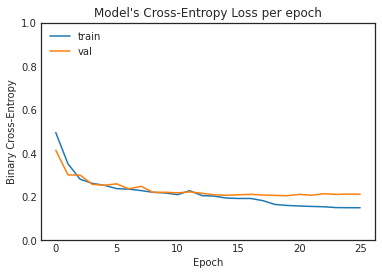

In [ ]:
# Visualize cross-entropy loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Cross-Entropy Loss per epoch")
plt.ylabel('Binary Cross-Entropy')
plt.xlabel('Epoch')
plt.axis([None, None, 0, 1])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

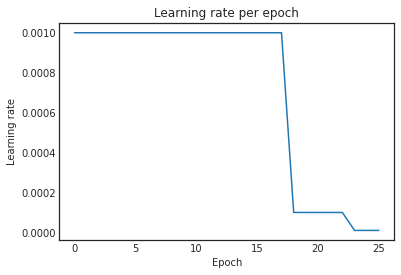

In [ ]:
# Visualize learning rate
plt.plot(history.history['lr'])
plt.title("Learning rate per epoch")
plt.ylabel('Learning rate')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Let's look at some validation predictions
preds_val = model.predict({'img': X_dev, 'depth': X_depth_dev}, verbose=1)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)


25/25 [==============================] - 1s 14ms/step


In [ ]:
preds_val.shape

(800, 128, 128, 1)

In [ ]:
# iou_metric_batch(preds_val, y_dev)


In [ ]:
len(preds_val)

800

Image with index 754


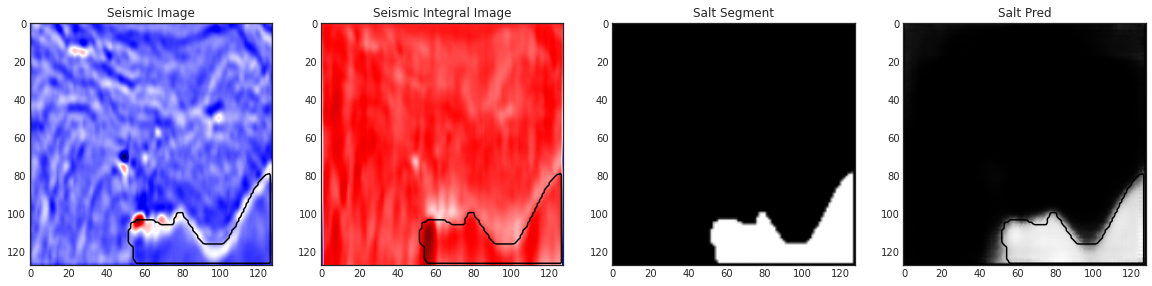

In [ ]:
plot_images(X_dev, y_dev, preds_val)


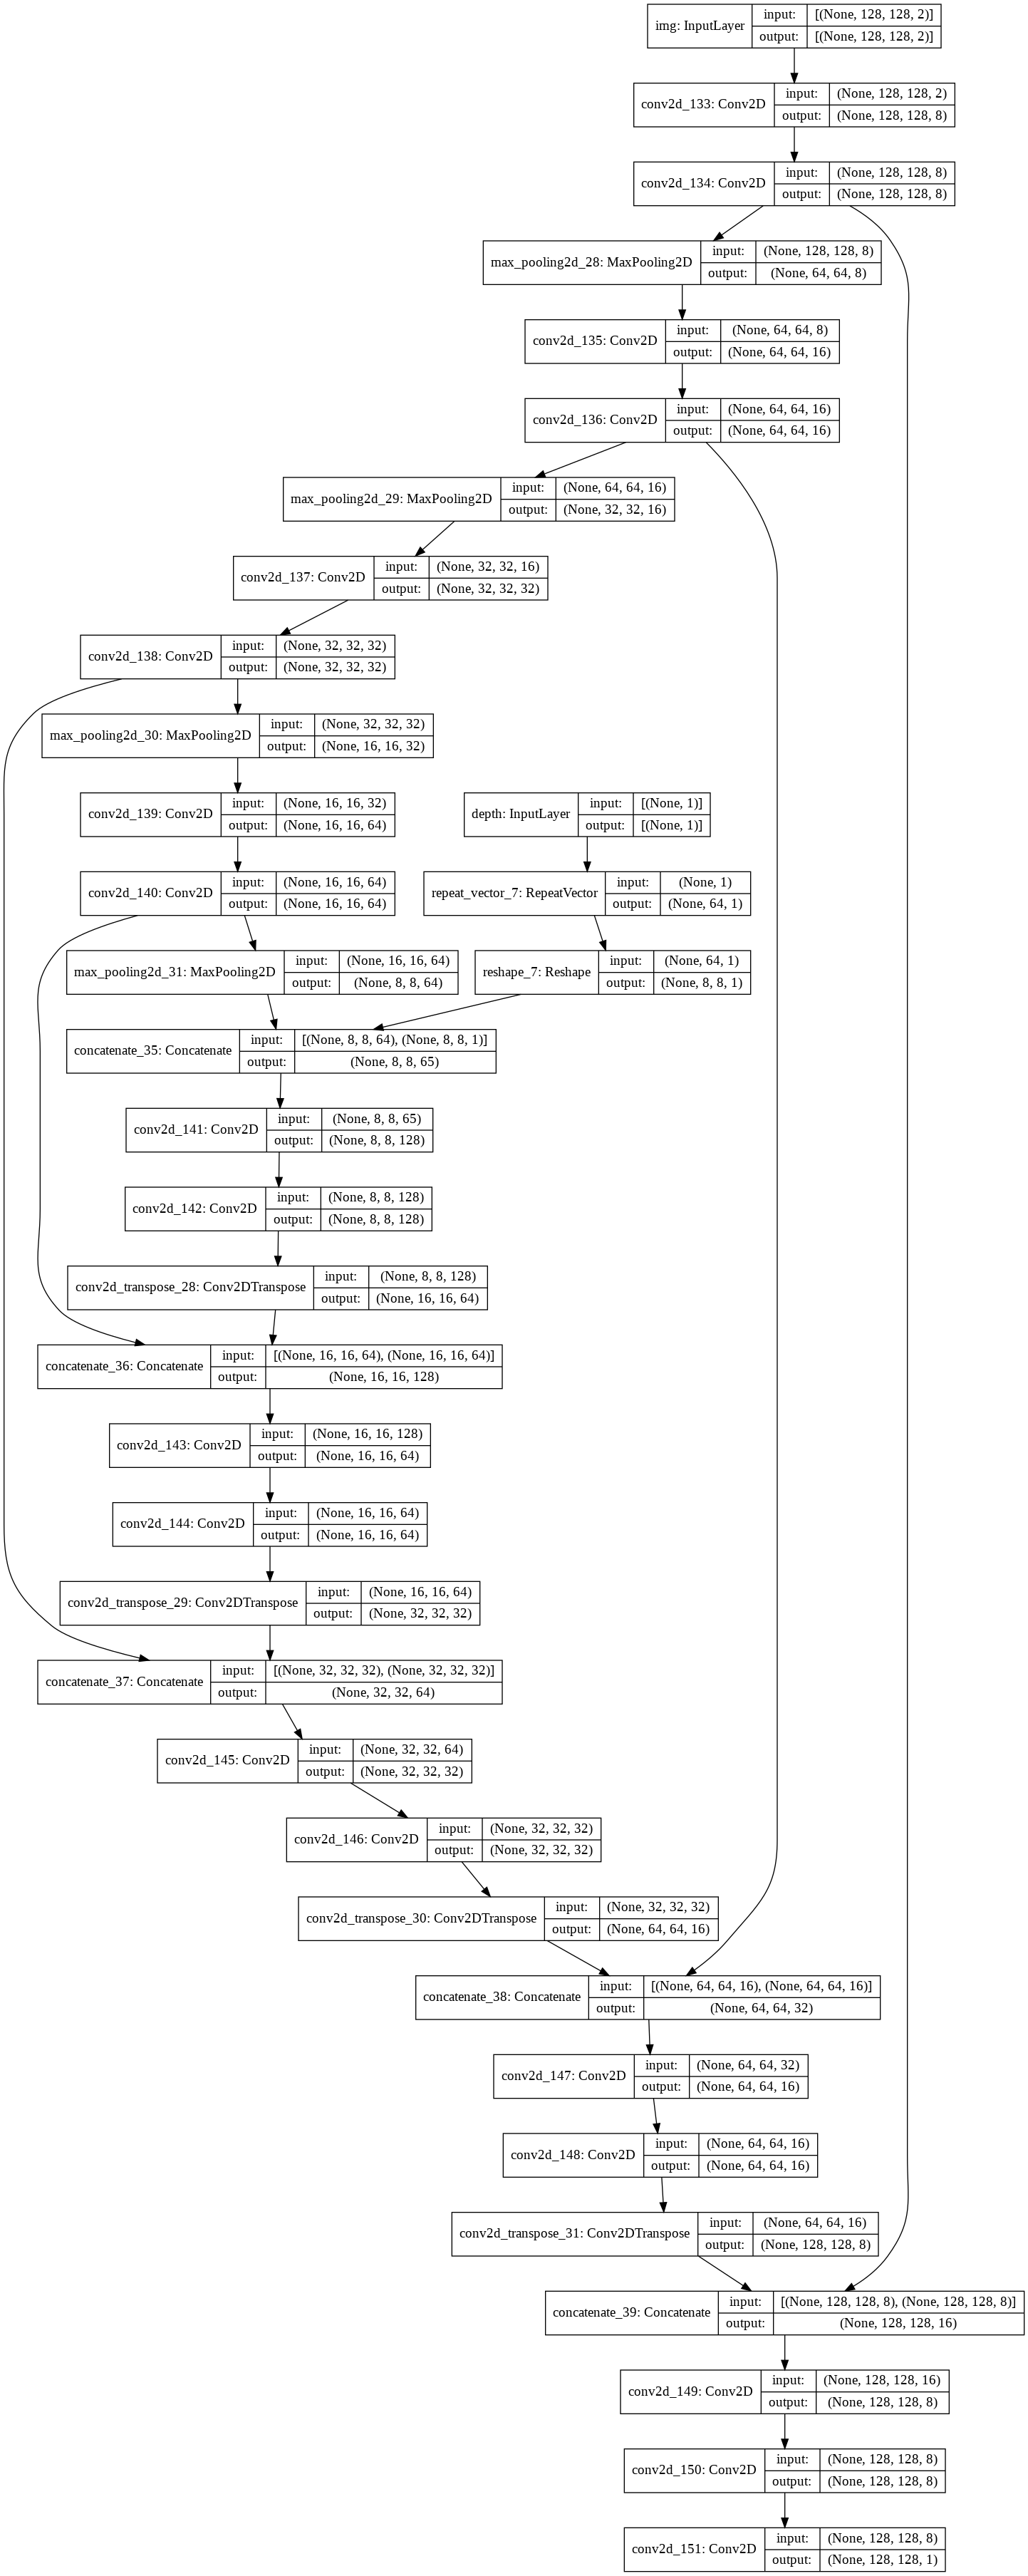

In [ ]:
# Plot model
# reference: https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, rankdir='HR')